In [1]:
library(Seurat)
library(Signac)
library(magrittr)
library(genomation)
library(GenomicRanges)
library(Matrix)
library(ggplot2)

Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built under R 4.3.2 but the current version is
4.3.3; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed

‘SeuratObject’ was built with package ‘Matrix’ 1.6.3 but the current
version is 1.6.5; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


Loading required package: grid

Warning message:
“replacing previous import ‘Biostrings::pattern’ by ‘grid::pattern’ when loading ‘genomation’”
Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:SeuratObject’:

    intersect


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDupl

Specify file path

In [2]:
dir.scE2G_res = "/maps/projects/ralab_nnfc-AUDIT/people/lpm537/software/scE2G_pipeline/240617/sc-E2G/test/results/Islets/"
path.obj.seurat = "/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/data/Islets/1.prepare_data/1.seurat_pipeline.240617/obj.seurat.qc2.rds"
dir.output = "/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/data/Islets/1.prepare_data/3.merge_peaks.241022/"

In [3]:
dir.create(dir.output,recursive = T)

Import seurat object

In [4]:
obj.seurat = readRDS(path.obj.seurat)

In [5]:
table(obj.seurat$cell_type)


     acinar       alpha        beta       delta        duct endothelial 
       6119       42072       36704        6216        1320         416 
     immune mesenchymal          PP 
        537        1445        1538 

Import E-G pairs for each cluster

In [6]:
list.pairs.E2G = list()
for (cell_type.tmp in unique(obj.seurat$cell_type)){
    list.pairs.E2G[[cell_type.tmp]] = readGeneric(paste(dir.scE2G_res,
                                                        "/",
                                                        cell_type.tmp,
                                                        ".multiome_7features/Kendall/Pairs.tsv.gz",sep = ""),
                                                  header = T,
                                                  keep.all.metadata = T)


}

In [7]:
list.ABC.1M = list()
for (cell_type.tmp in unique(obj.seurat$cell_type)){
    bed.tmp = readGeneric(paste(dir.scE2G_res,
                                "/",
                                cell_type.tmp,
                                ".multiome_7features/Predictions/EnhancerPredictionsAllPutative.tsv.gz",
                                sep = ""),
                          header = T,
                          keep.all.metadata = T)
    list.ABC.1M[[cell_type.tmp]] = bed.tmp[bed.tmp$distance < 10^6]
    rm(bed.tmp)
}

Check peak width

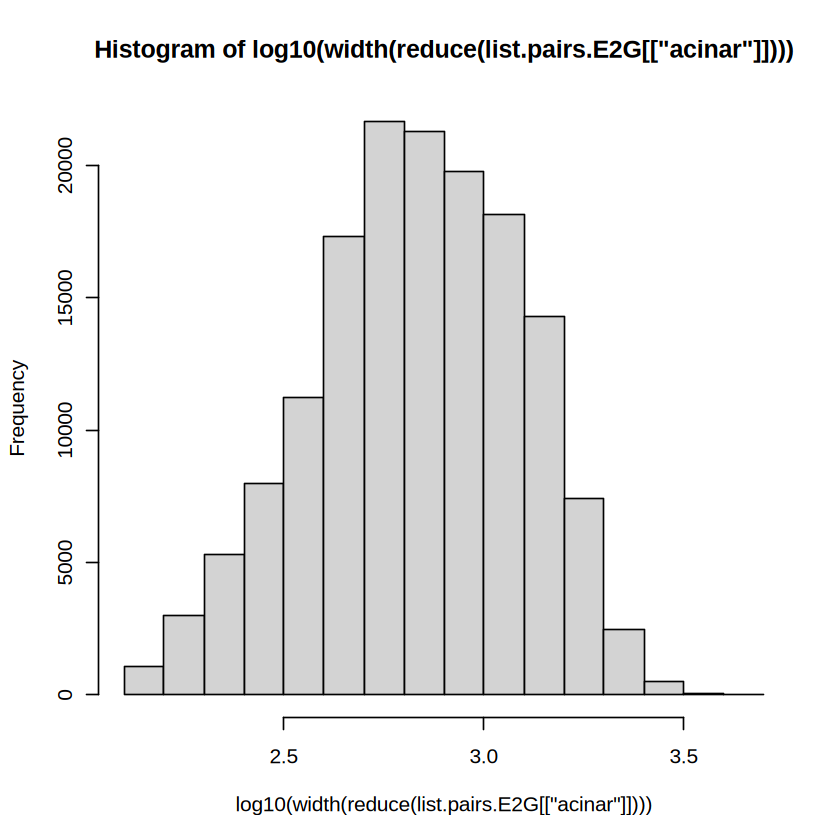

In [8]:
hist(log10(width(reduce(list.pairs.E2G[["acinar"]]))))

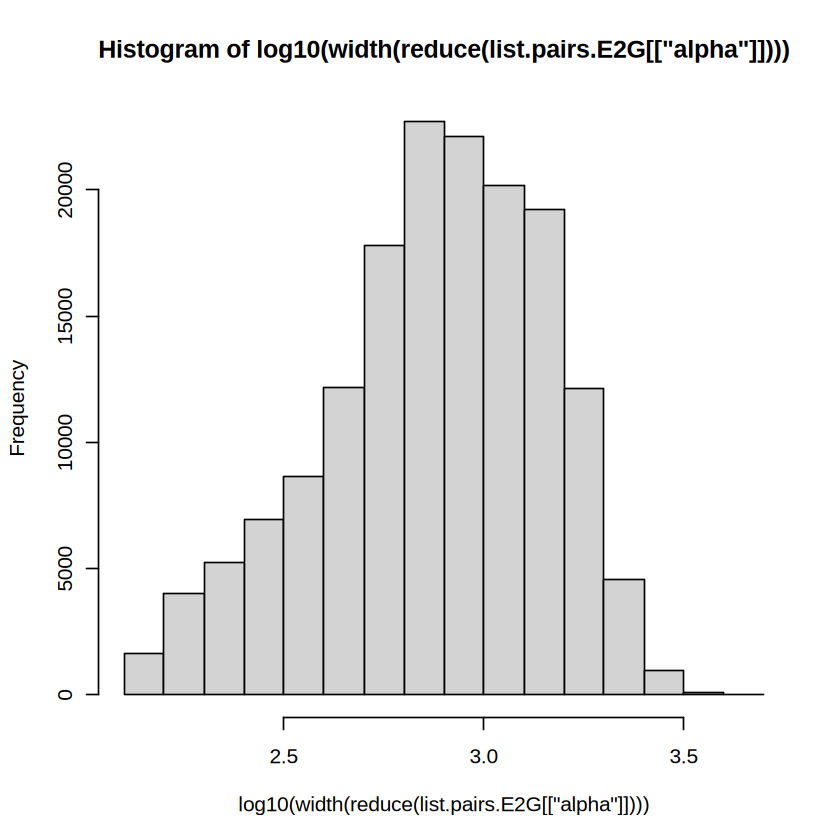

In [9]:
hist(log10(width(reduce(list.pairs.E2G[["alpha"]]))))

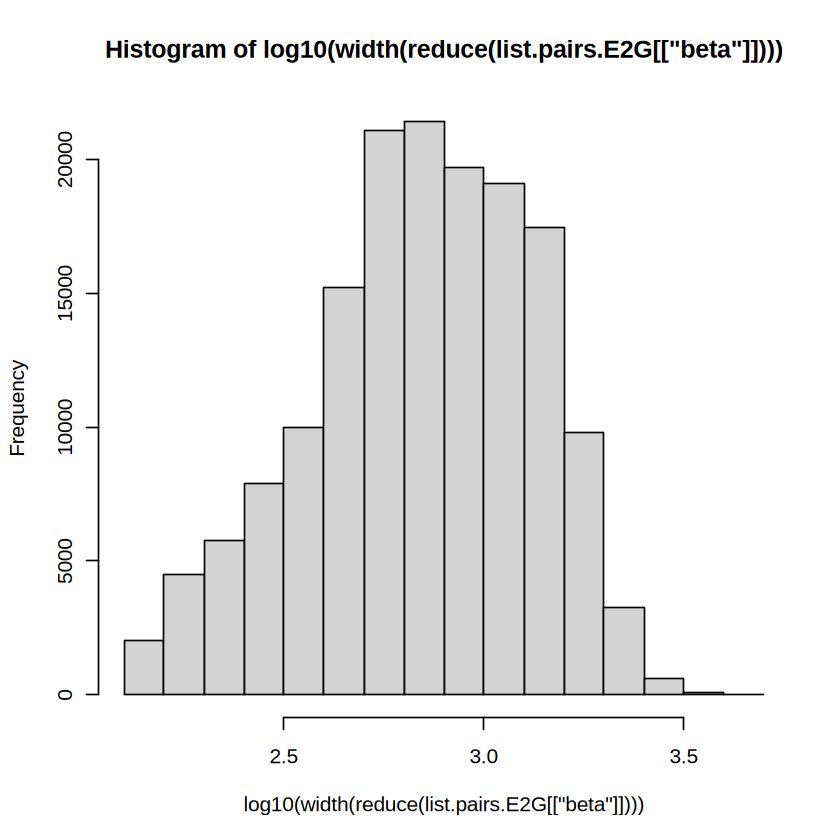

In [10]:
hist(log10(width(reduce(list.pairs.E2G[["beta"]]))))

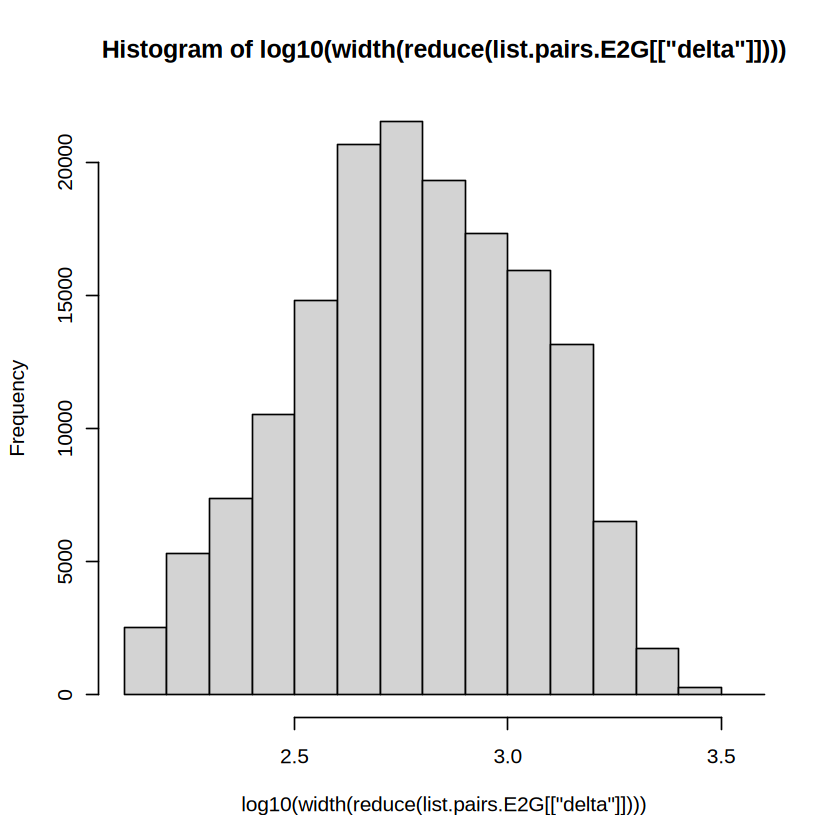

In [11]:
hist(log10(width(reduce(list.pairs.E2G[["delta"]]))))

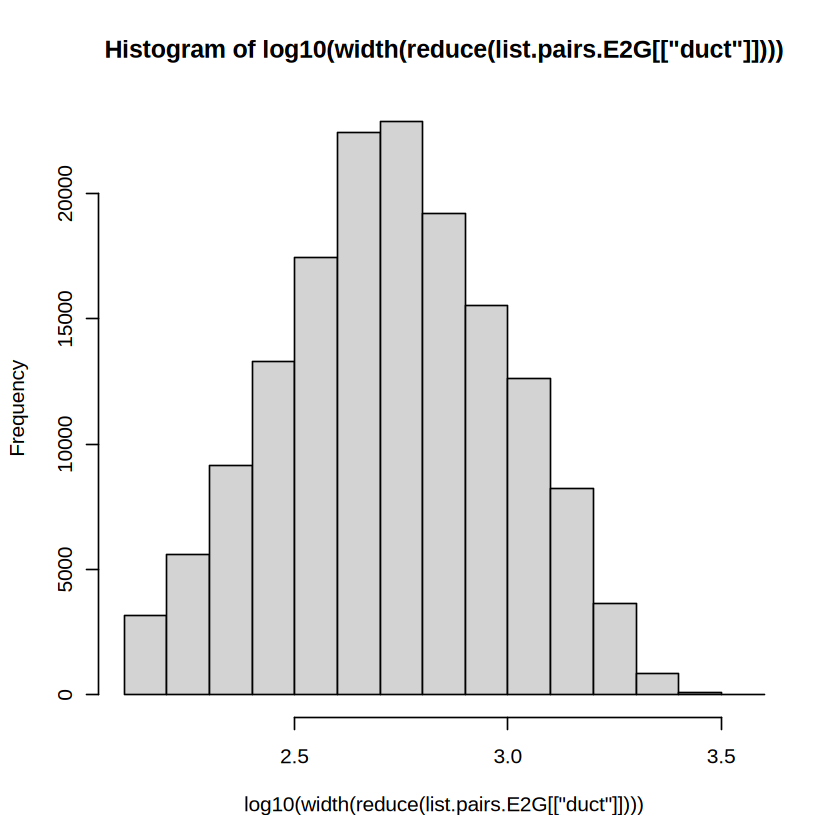

In [12]:
hist(log10(width(reduce(list.pairs.E2G[["duct"]]))))

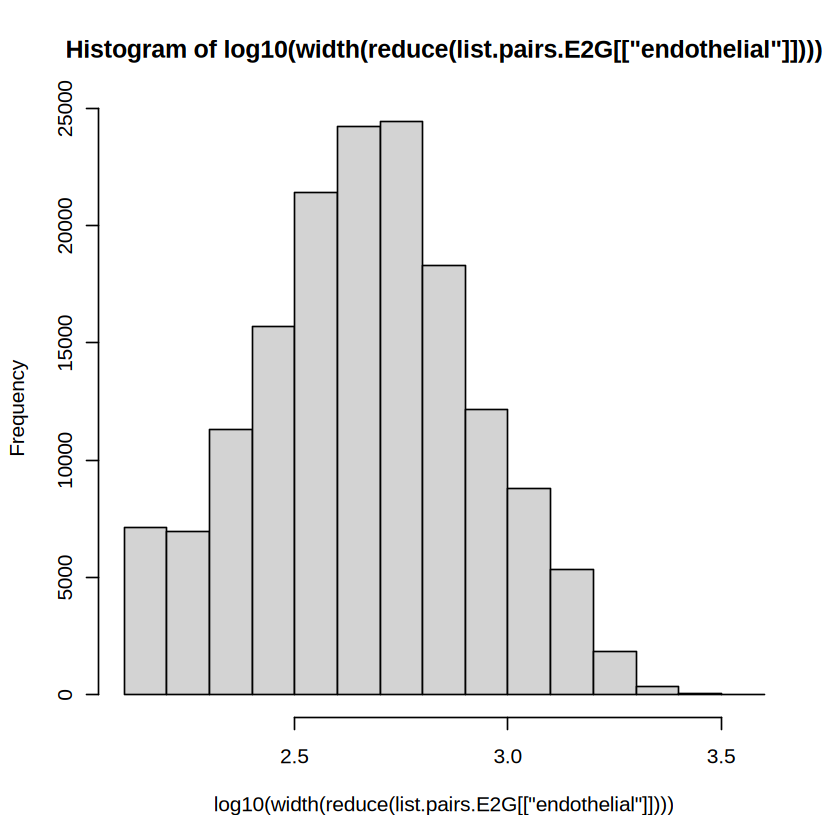

In [13]:
hist(log10(width(reduce(list.pairs.E2G[["endothelial"]]))))

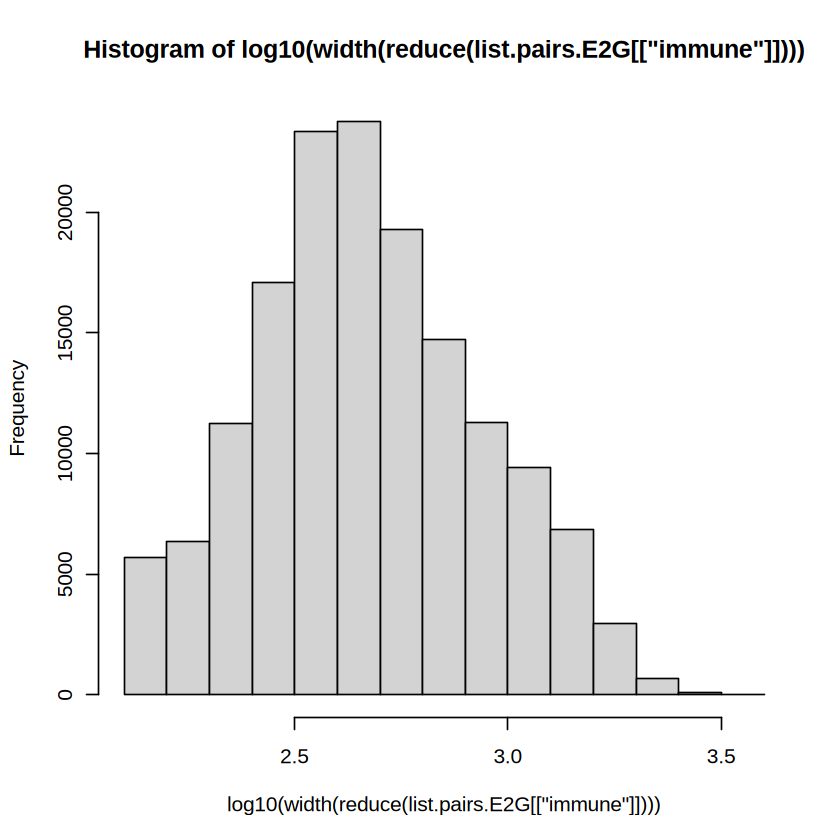

In [14]:
hist(log10(width(reduce(list.pairs.E2G[["immune"]]))))

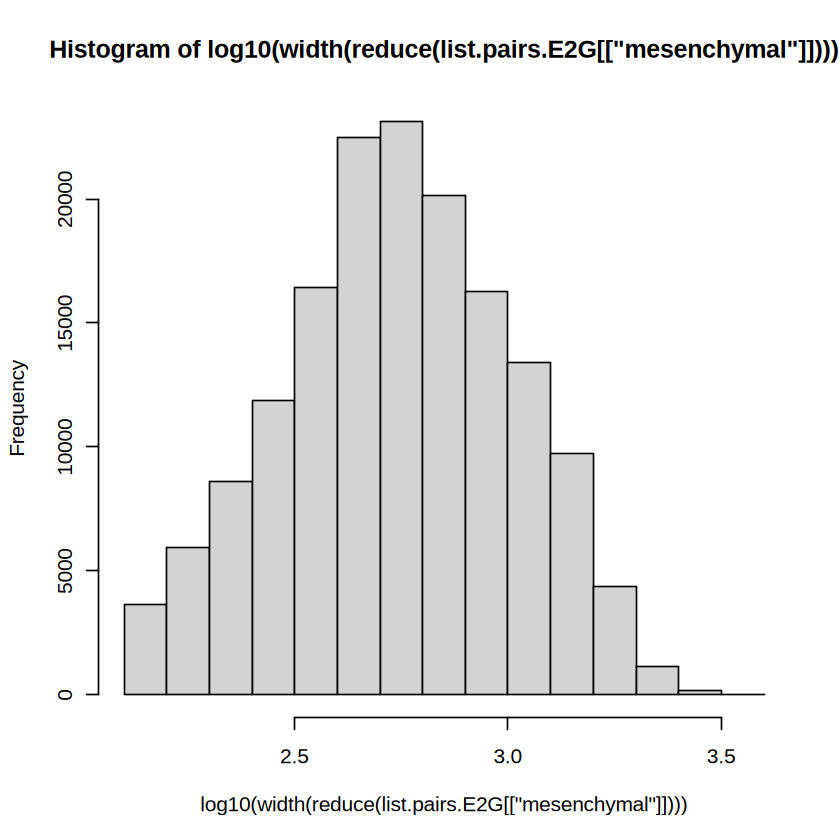

In [15]:
hist(log10(width(reduce(list.pairs.E2G[["mesenchymal"]]))))

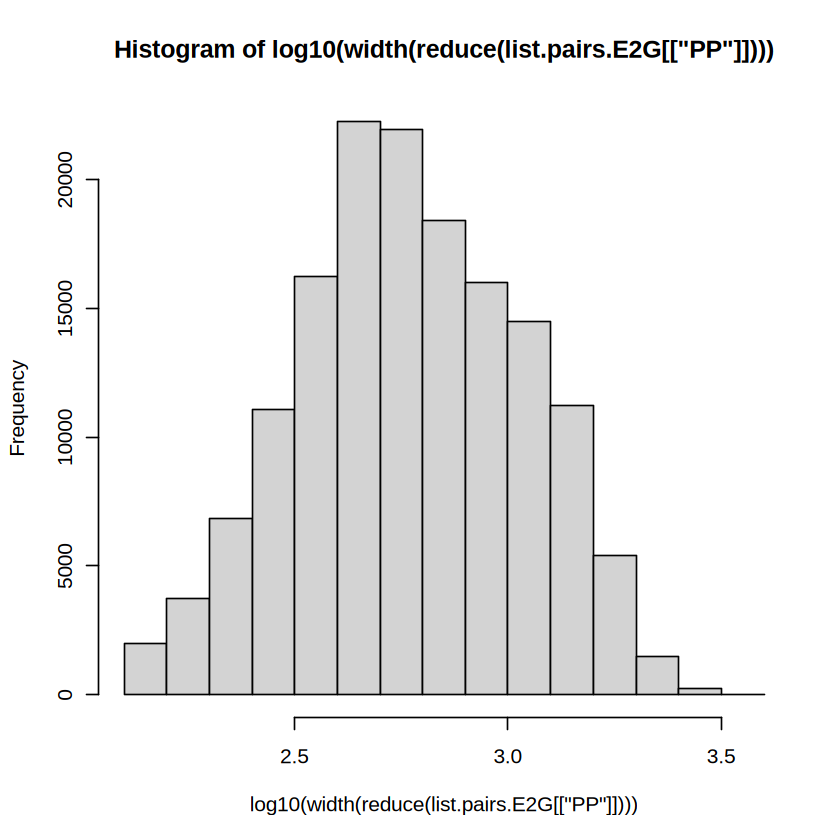

In [16]:
hist(log10(width(reduce(list.pairs.E2G[["PP"]]))))

Merge peaks

In [17]:
bed.peaks = reduce(unlist(as(list.pairs.E2G, "GRangesList")))
bed.peaks

GRanges object with 399857 ranges and 0 metadata columns:
           seqnames              ranges strand
              <Rle>           <IRanges>  <Rle>
       [1]     chr1          9932-10679      *
       [2]     chr1         29238-29476      *
       [3]     chr1         91051-91548      *
       [4]     chr1         99511-99853      *
       [5]     chr1       102772-103193      *
       ...      ...                 ...    ...
  [399853]     chrX 156021749-156021992      *
  [399854]     chrX 156024978-156025515      *
  [399855]     chrX 156028727-156029113      *
  [399856]     chrX 156029324-156030335      *
  [399857]     chrX 156030456-156030869      *
  -------
  seqinfo: 23 sequences from an unspecified genome; no seqlengths

Make E-G pairs

In [18]:
pair.ABC.1M = unlist(as(list.ABC.1M, "GRangesList"))

In [19]:
overlaps.res = findOverlaps(bed.peaks,
                            pair.ABC.1M)

In [20]:
pairs.peak_gene = bed.peaks[overlaps.res@from]
mcols(pairs.peak_gene)[,"TargetGene"] = mcols(pair.ABC.1M)[overlaps.res@to,"TargetGene"]
mcols(pairs.peak_gene)[,"PeakName"] = 
  paste(seqnames(pairs.peak_gene),
        start(pairs.peak_gene),
        end(pairs.peak_gene),
        sep = "-")

In [21]:
mcols(pairs.peak_gene)[,"PairName"] = 
  paste(mcols(pairs.peak_gene)[,"PeakName"],
        mcols(pairs.peak_gene)[,"TargetGene"],
        sep = "_")
pairs.peak_gene = pairs.peak_gene[order(mcols(pairs.peak_gene)[,"PairName"])]
pairs.peak_gene = pairs.peak_gene[!duplicated(mcols(pairs.peak_gene)[,"PairName"])]
pairs.peak_gene

GRanges object with 6421068 ranges and 3 metadata columns:
            seqnames              ranges strand |  TargetGene
               <Rle>           <IRanges>  <Rle> | <character>
        [1]     chr1 100024293-100024741      * |         AGL
        [2]     chr1 100024293-100024741      * |      CDC14A
        [3]     chr1 100024293-100024741      * |         DBT
        [4]     chr1 100024293-100024741      * |       EXTL2
        [5]     chr1 100024293-100024741      * |     MFSD14A
        ...      ...                 ...    ... .         ...
  [6421064]     chrX     9995565-9996629      * |        WWC3
  [6421065]     chrX     9997615-9997859      * |       CLCN4
  [6421066]     chrX     9997615-9997859      * |     SHROOM2
  [6421067]     chrX     9997615-9997859      * |       TBL1X
  [6421068]     chrX     9997615-9997859      * |        WWC3
                          PeakName               PairName
                       <character>            <character>
        [1] chr1-10

Generate peak x cell matrix

In [22]:
bed.peaks.matrix = reduce(pairs.peak_gene)
bed.peaks.matrix

GRanges object with 395970 ranges and 0 metadata columns:
           seqnames              ranges strand
              <Rle>           <IRanges>  <Rle>
       [1]     chr1          9932-10679      *
       [2]     chr1         29238-29476      *
       [3]     chr1         91051-91548      *
       [4]     chr1         99511-99853      *
       [5]     chr1       102772-103193      *
       ...      ...                 ...    ...
  [395966]     chrX 156021749-156021992      *
  [395967]     chrX 156024978-156025515      *
  [395968]     chrX 156028727-156029113      *
  [395969]     chrX 156029324-156030335      *
  [395970]     chrX 156030456-156030869      *
  -------
  seqinfo: 23 sequences from an unspecified genome; no seqlengths

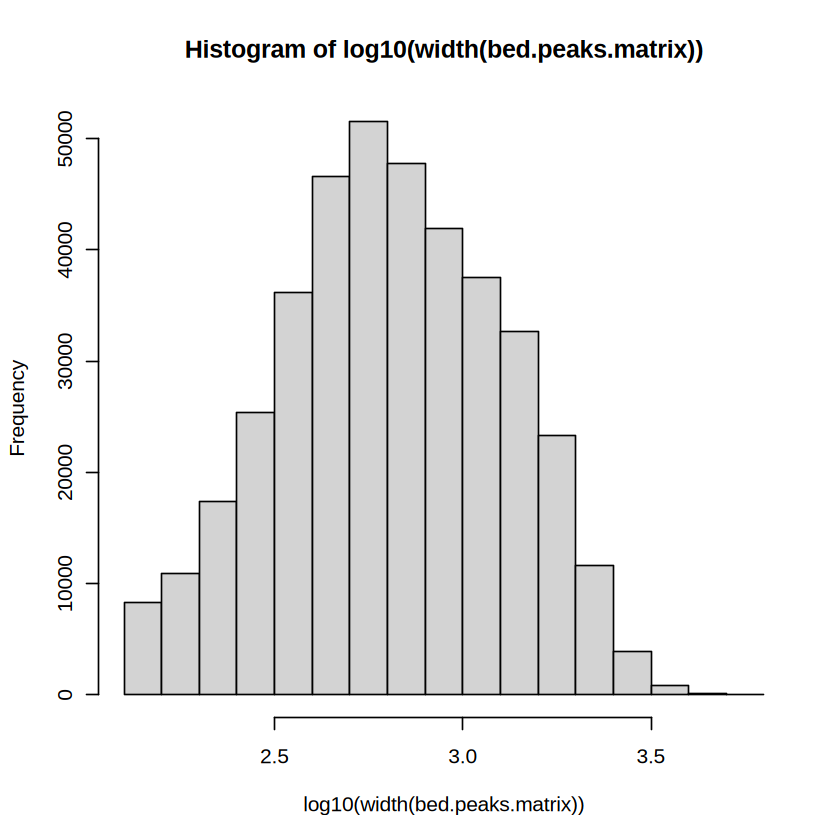

In [23]:
hist(log10(width(bed.peaks.matrix)))

Generate ATAC matrix

In [24]:
future::plan("multicore", workers = 32)
atac.matrix <- FeatureMatrix(
  fragments = obj.seurat@assays$ATAC_empty@fragments,
  features = bed.peaks.matrix,
  cells = colnames(obj.seurat@assays$RNA$counts)
)
future::plan("sequential")

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions



In [25]:
obj.seurat[["ATAC"]] <- CreateChromatinAssay(
  counts = atac.matrix,
  fragments = obj.seurat@assays$ATAC_empty@fragments
)
DefaultAssay(obj.seurat) <- "ATAC"

In [26]:
obj.seurat <- obj.seurat %>%
  RunTFIDF() %>%
  FindTopFeatures(min.cutoff = 'q0') %>%
  RunSVD() %>%
  RunUMAP(reduction = 'lsi', dims = 2:30)

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
13:15:24 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

13:15:24 Read 96367 rows and found 29 numeric columns

13:15:24 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

13:15:24 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*


In [27]:
dir.create("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/output/Islets/1.prepare_data/3.merge_peaks.241022/",recursive = T)

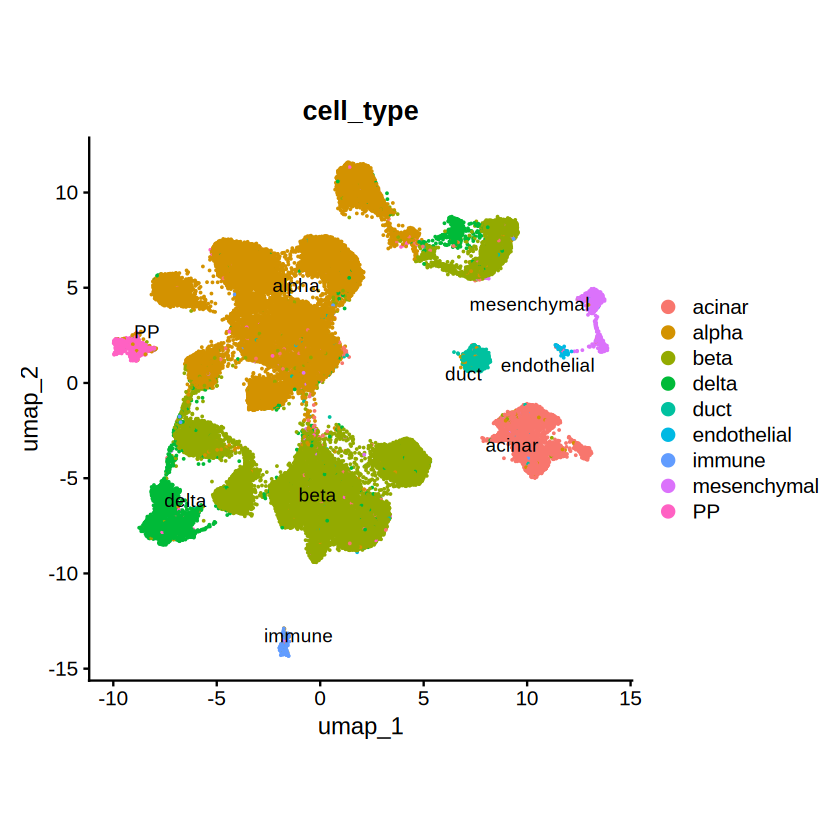

In [28]:
p = DimPlot(obj.seurat, 
        group.by = "cell_type",
        label = TRUE, 
        repel = TRUE, 
        reduction = "umap")  +
  theme(aspect.ratio=1)
p
ggsave("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/output/Islets/1.prepare_data/3.merge_peaks.241022/UMAP.ATAC.cell_type.pdf", 
       plot = p, 
       width = 10, height = 8)

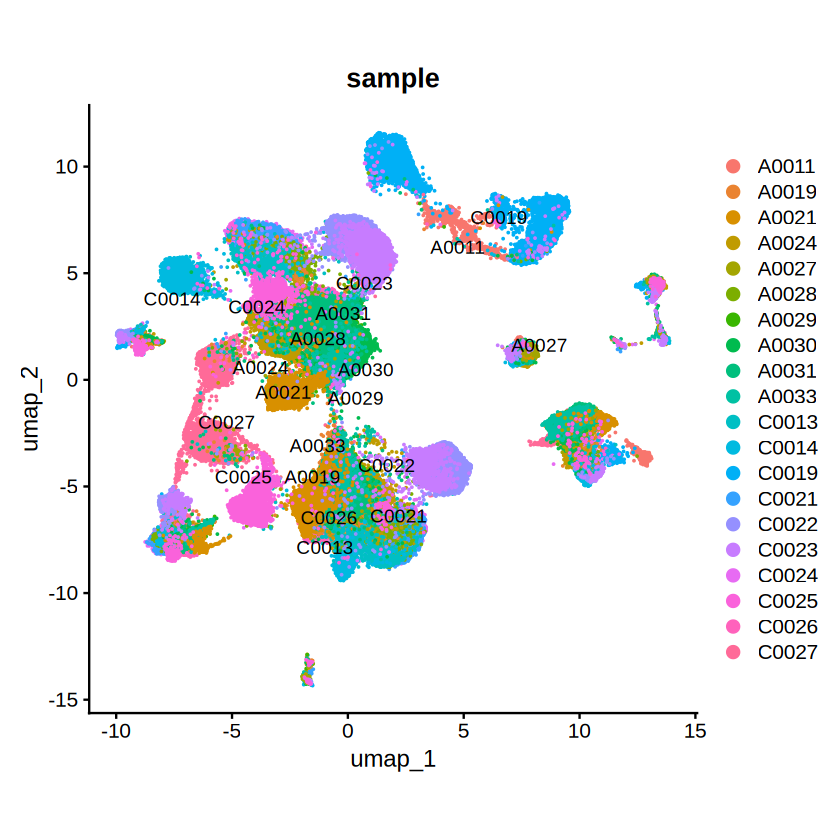

In [29]:
p = DimPlot(obj.seurat, 
        group.by = "sample",
        label = TRUE, 
        repel = TRUE, 
        reduction = "umap")  +
  theme(aspect.ratio=1)
p
ggsave("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/output/Islets/1.prepare_data/3.merge_peaks.241022/UMAP.ATAC.sample.pdf", 
       plot = p, 
       width = 10, height = 8)

Save data

In [30]:
saveRDS(obj.seurat,
        paste(dir.output, "obj.seurat.rds", sep = "/"))

In [31]:
saveRDS(obj.seurat@assays$RNA$counts,
        paste(dir.output, "matrix.rna.rds", sep = "/"))

In [32]:
saveRDS(obj.seurat@assays$ATAC$counts,
        paste(dir.output, "matrix.atac.rds", sep = "/"))

In [33]:
saveRDS(pairs.peak_gene,
        paste(dir.output, "pairs.rds", sep = "/"))

In [34]:
data.table::fwrite(as.data.frame(as.matrix(obj.seurat@assays$ATAC$counts)),
                   paste(dir.output, "matrix.atac.csv.gz", sep = "/"),
                   row.names = T)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 284.3 GiB”


In [35]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux 8.10 (Ootpa)

Matrix products: default
BLAS/LAPACK: /maps/projects/ralab/people/lpm537/software/anaconda3/envs/Notebook_E2G_240505/lib/libopenblasp-r0.3.27.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Copenhagen
tzcode source: system (glibc)

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ggplot2_3.5.1        Matrix_1.6-5         GenomicRanges_1.54.1
 [4] GenomeInfoDb_1.38.1  IRanges_2.36.0       S4Vectors_0.40.2   